In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd



import numpy as np
import matplotlib.pyplot as plt


from glob import glob

import os, sys

sys.path.append('/Users/silas/Documents/switchdrive/')
import helper_scripts as hs

from io import StringIO


import seaborn as sns
from helper_scripts import DimensionalReduction,MetaTable
from helper_scripts import effect_plot as EP




In [2]:
working_dir='../WD/'

In [3]:
metadata= pd.read_table(f'../metadata.tsv',index_col=0)

In [4]:
figurefolder="/Volumes/m-phyme/GTrajkovs/Claire/Warm microbiota/warm microbiota paper/figure metagenome"
SAVEPLOT=False
figurefolder="Figures"
plot_params=dict(figurefolder=figurefolder,SAVEPLOT=SAVEPLOT,formats=['.png','.svg'])

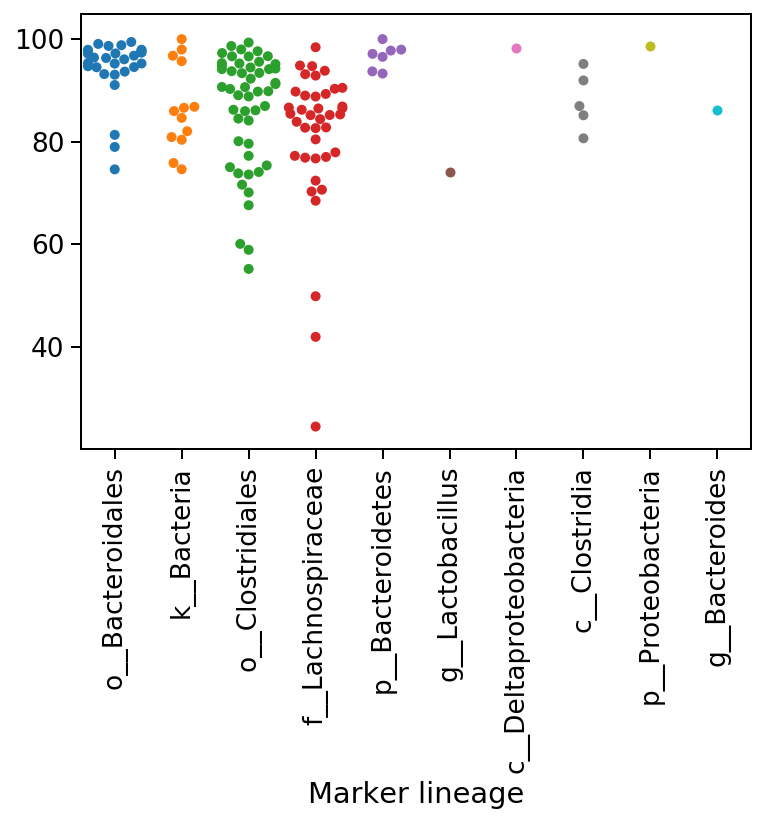

In [5]:
GenomeInfo= pd.concat((pd.read_table(f'{working_dir}/genomes/checkm/completeness.tsv',index_col=0),
                     pd.read_table(f'{working_dir}/genomes/checkm/taxonomy.tsv',index_col=0)),1).dropna(how='all',axis=1)



checkmTax = pd.DataFrame(list(GenomeInfo['Taxonomy (contained)'].apply(lambda s: s.split(';'))),
                       index=GenomeInfo.index)
checkmTax.columns=['Kindom','Phylum','Class','Order','Family','Genus']


ax=sns.swarmplot(y=GenomeInfo.Completeness-5*GenomeInfo.Contamination,x=GenomeInfo['Marker lineage'].map(lambda s: s.split()[0]))
_ =ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [6]:
DT= pd.read_table(f'{working_dir}/genomes/taxonomy/taxonomy_names.tsv')
DT= DT.drop_duplicates(['# bin']).sort_values('# bin')

DT.index= DT['# bin']

Tax= DT.loc[:,'superkingdom':].fillna('not classified')
Tax= Tax.applymap(lambda s: s.split(':')[0])
Tax= Tax.replace('not classified',np.nan)
Tax=Tax.fillna(method='ffill',axis=1)

Labels=Tax.species+' '+Tax.index

# Genomeprop

In [7]:
Pathways = pd.read_csv(f'{working_dir}/genomes/annotations/GenomeProperties.tsv',sep='\t',index_col=0).T
Pathways=Pathways.replace({'YES':1.,'NO':0,'PARTIAL':0.5})

In [8]:
from pygenprop.database_file_parser import parse_genome_property_file
genprop_tree = parse_genome_property_file(open('/Users/silas/Documents/GitHub/genome-properties/flatfiles/genomeProperties.txt'))

Description= pd.Series(index=Pathways.columns)
for gp in Description.index:
    Description.loc[gp]=genprop_tree[gp].name

Leave_Ids= [gp.id for gp in genprop_tree.leafs]

In [9]:
I = Pathways#[Leave_Ids]

## PCA on genes

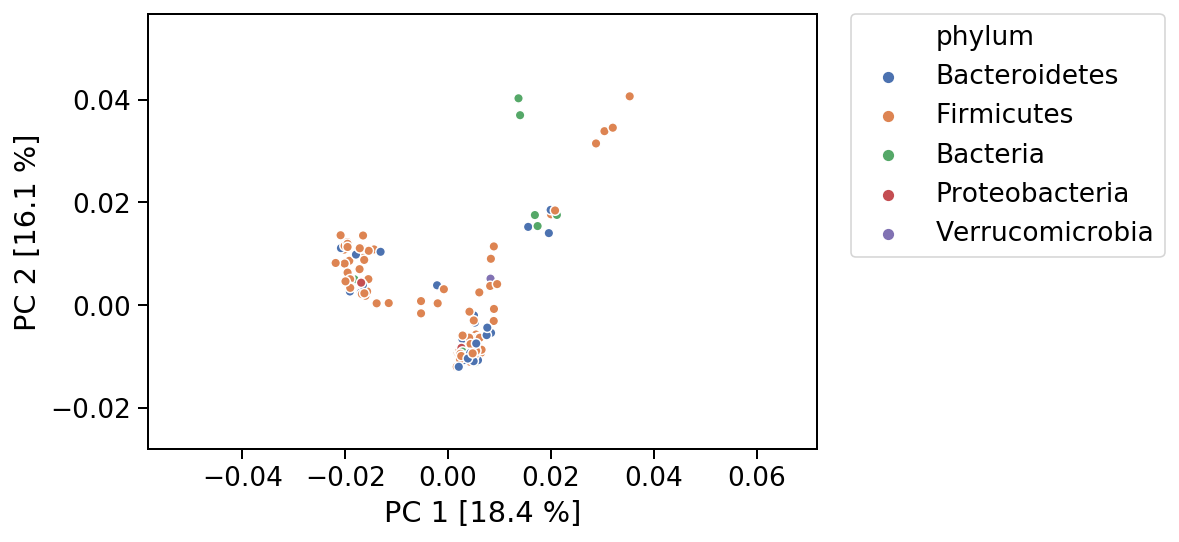

In [10]:


DR =DimensionalReduction.DimensionalReduction((I.T/I.sum(1)).T) #((I.T-I.mean(1))/I.std(1)).T)

#pl=DR.plot_Components_2D(hue = I.sum(1),palette='Greens')


#plt.show()

DR.plot_Components_2D(hue=Tax.phylum,palette='deep')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# aggregate genes

In [11]:
presence_absence= (I>0.5)*1.
presence_absence= presence_absence.loc[:,presence_absence.std()>0]


## Ratio

In [12]:

D = pd.read_table(f'{working_dir}/genomes/counts/median_coverage_genomes.tsv',index_col=0)


#D = (D.T/D.sum(1)).T
D.head()

,MAG001,MAG002,MAG003,MAG004,MAG005,MAG006,MAG007,MAG008,MAG009,MAG010,...,MAG138,MAG139,MAG140,MAG141,MAG142,MAG143,MAG144,MAG145,MAG146,MAG147
shHC1,34.54,10.13,0.0,1.10,9.60,1.45,0.10,5.24,0.00,0.0,...,4.325,6.03,0.11,2.62,3.67,5.84,0.0,4.18,3.16,0.0
shHC2,24.76,8.30,0.0,0.13,1.01,3.84,0.25,0.00,0.23,0.0,...,1.540,9.81,0.00,1.88,0.00,4.68,0.0,3.19,5.43,0.2
shHC3,36.42,9.65,0.0,0.20,4.94,0.20,0.00,0.00,0.00,0.4,...,9.220,7.22,2.12,1.98,1.43,2.48,0.0,2.59,0.78,0.0
shHC4,30.76,22.50,0.0,1.65,4.91,2.15,0.00,0.00,0.00,0.0,...,4.730,14.53,0.20,0.00,0.00,23.56,0.0,9.92,10.44,0.0
shHC5,24.87,7.43,0.2,0.40,4.52,0.40,0.90,0.00,0.00,0.0,...,4.200,3.51,0.22,2.03,1.00,0.56,0.0,3.51,0.39,0.2


In [13]:
present= D.loc[:,presence_absence.index]@presence_absence
present=np.log2(present.replace(0,10e-10))
absent= D.loc[:,presence_absence.index]@(1-presence_absence)
absent=np.log2(absent.replace(0,10e-10))

Genes= present-absent

/Users/silas/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


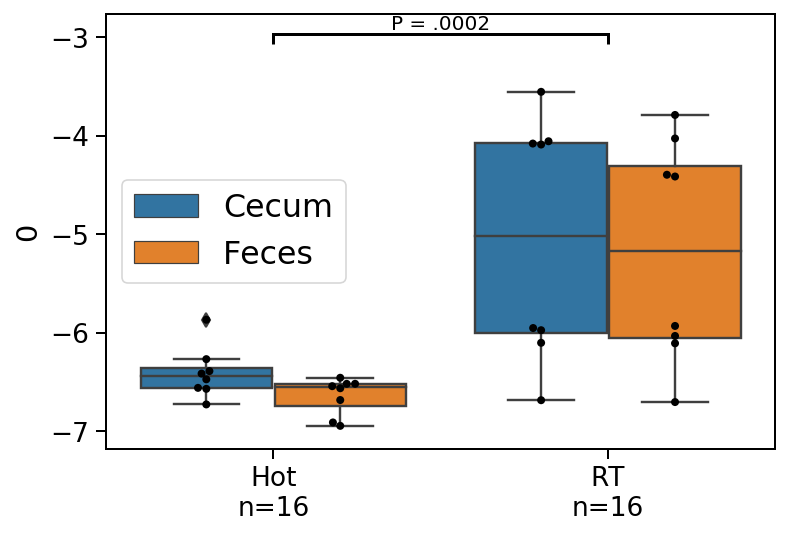

In [14]:
hs.Viewpoint(Genes.mean(1),
             grouping_variable=metadata.Group, grouping_variable2=metadata.Source).Boxplot(0)


## CLR

/Users/silas/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


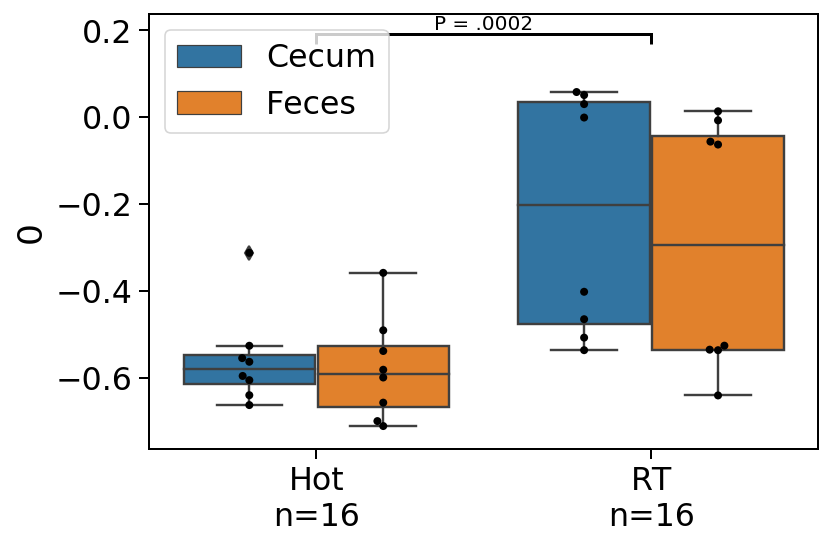

In [16]:

Counts= pd.read_table(f'{working_dir}/genomes/counts/raw_counts_genomes.tsv',index_col=0)

from skbio.stats.composition import multiplicative_replacement

D= pd.DataFrame(MetaTable.clr(multiplicative_replacement(Counts)), 
    index=Counts.index, columns= Counts.columns)


Genes= D.loc[:,presence_absence.index]@presence_absence

Genes= Genes.astype(float)


Genes= Genes/presence_absence.sum()



hs.Viewpoint(Genes.mean(1),
             grouping_variable=metadata.Group, grouping_variable2=metadata.Source).Boxplot(0)


# PCA

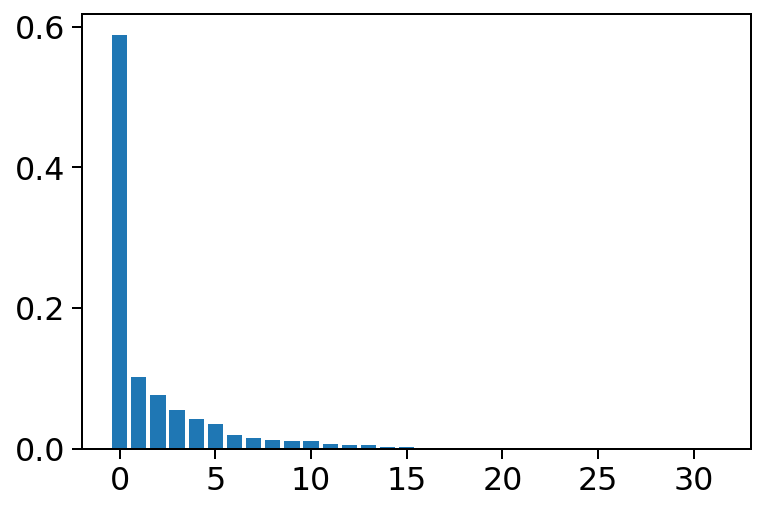

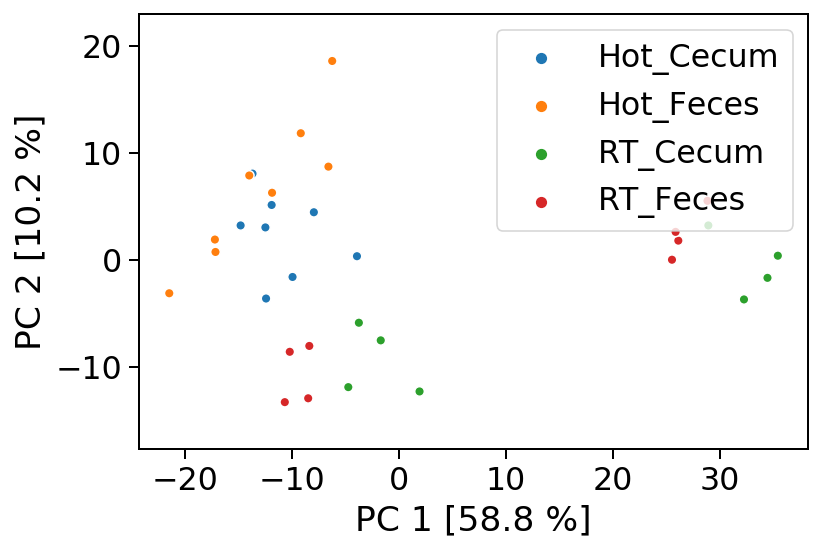

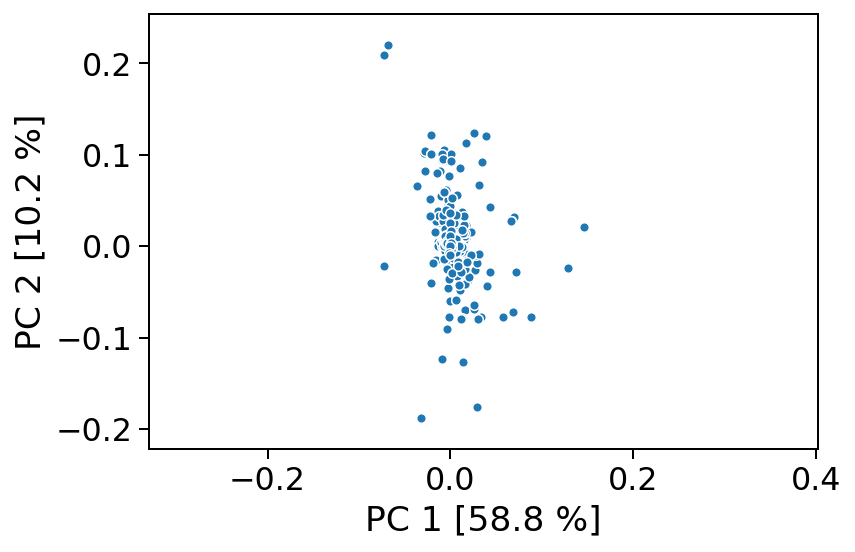

In [17]:


DR= DimensionalReduction.DimensionalReduction(Genes)

plt.bar(np.arange(DR.decomposition.explained_variance_ratio_.shape[0]),
        DR.decomposition.explained_variance_ratio_)
plt.show()
DR.plot_Components_2D (
                hue=metadata.Group+'_'+metadata.Source)

hs.plotting.saveplot('PCA_pathways',**plot_params)

plt.show()
DR.plot_Loadings_2D()

In [19]:
sig= DR.components.columns[DR.components.loc[1].abs()>0.1]

Description.loc[sig]

Genome_Property_ID
GenProp0786    Lysine biosynthesis via diaminopimelate (DAP),...
GenProp1466                           L-ornithine biosynthesis I
GenProp1333               Superpathway of L-alanine biosynthesis
GenProp0222                     Protoheme from protoporphyrin IX
GenProp0466                           Molybdopterin biosynthesis
GenProp1138                               Molybdopterin synthase
GenProp1446    Adenosine deoxyribonucleotides de novo biosynt...
GenProp1586    Adenosine deoxyribonucleotides de novo biosynt...
GenProp1343    Guanosine deoxyribonucleotides de novo biosynt...
GenProp1284       5-Aminoimidazole ribonucleotide biosynthesis I
GenProp1406    Superpathway of purine nucleotides de novo bio...
GenProp1484    Superpathway of guanosine nucleotides de novo ...
GenProp0204    KDO(2)-lipid A (Re LPS) biosynthesis and delivery
GenProp1290                               Lipid IVA biosynthesis
GenProp0704       tRNA U34 carboxymethylaminomethyl modification
GenPro

# metatable

In [20]:
order=['RT','Hot']
table_params=dict(sample_data=metadata,
             test_variable='Group',
            grouping_variables='Source',
            order_test=order, order_grouping=['Cecum','Feces'],
            colors= ['grey',sns.color_palette('deep')[3]])




In [21]:
M= MetaTable.Viewpoint(Genes,feature_data=Description, **table_params)
M.calculate_stats(comparisons=[order],test='kruskal')

In [22]:



Stats = M.stats.copy()
Stats.columns= Stats.columns.droplevel(-1)

S=Stats['pBH']

Medians= M.data.groupby([M.test_variable,M.grouping_variables]).median().T
Ab=Medians.groupby(axis=1,level=1).max()

effect='median_diff'#'log2FC'

if effect=='log2FC':
    if all(M.data>=0):#when relab
        Medianslog= Medians.replace(0,0.00001).apply(np.log2)
        Effect= Medianslog['Hot']-Medianslog['RT']
        del Medianslog
        
else:
    Effect=Stats[effect]







    


In [26]:
Source='Feces'
#sig= (S[Source]<0.05) &(FC[Source].abs()>0.5)


#sig= (S[Source]<0.01)& (Ab[Source]>0.1)& (Effect[Source].abs()>0.5)
sig= (S[Source]<0.05)&(Effect[Source].abs()>0.5)

#sig= (S[Source]<0.05)& (Ab[Source]>0.01) & (Effect[Source].abs()>0.5)
sig_label='large'

sig= Effect.loc[sig,Source].sort_values(ascending=False).index
len(sig)

32

In [27]:
"GenProp0190" in sig

False

In [28]:
amines="GenProp" + pd.Series(['1571', '0219','0641','1272','1610'])#+['1433',"0642",
#"0643", "0644","1733"])

#sig_label='amines'

amines= Effect.loc[amines,Source].sort_values(ascending=False).index

Description.name='Description'
Effect.loc[amines].join(Description)

,Cecum,Feces,Description
Genome_Property_ID,,,
GenProp0641,0.006242,0.073092,Spermidine biosynthesis from putrescine and S-...
GenProp1571,0.006242,0.073092,Spermine biosynthesis
GenProp0219,-0.149939,-0.171380,Spermidine biosynthesis from arginine (via agm...
GenProp1272,0.040692,-0.193052,Spermine and spermidine degradation III
GenProp1610,0.013912,-0.197888,Spermine and spermidine degradation I


Text(0, 0.5, '')

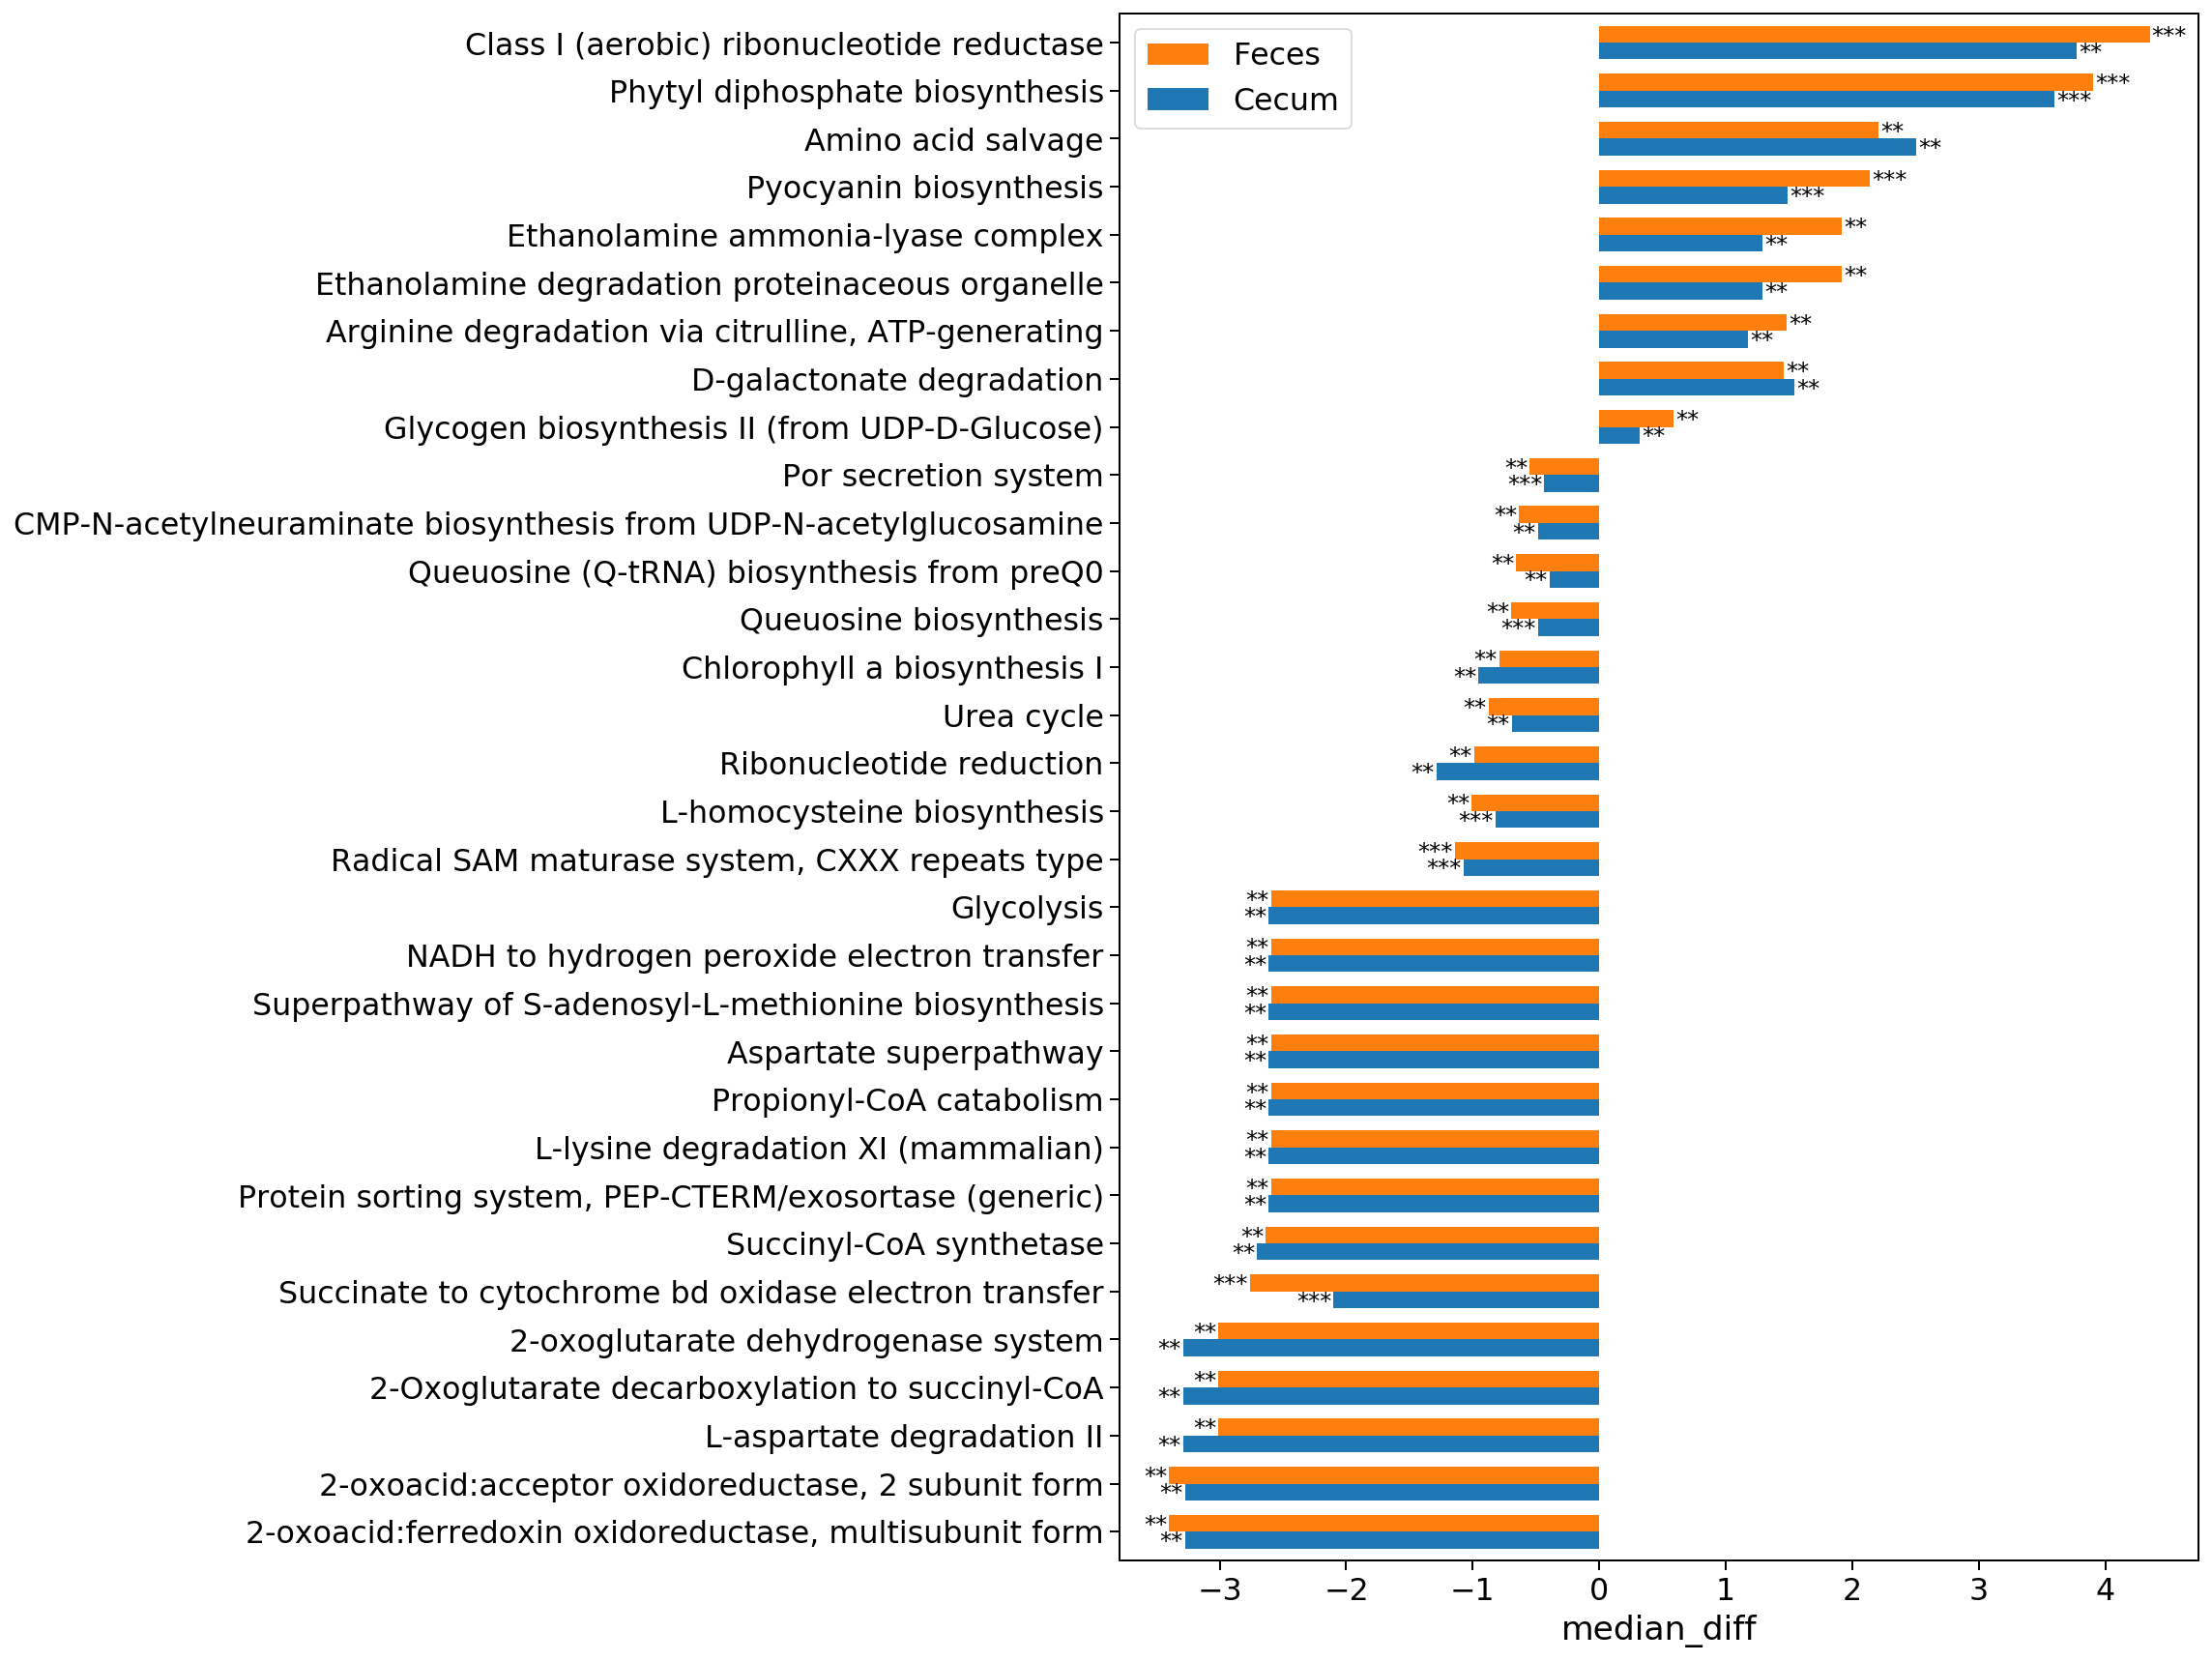

In [29]:
EP.effect_plot(Effect.loc[sig], Stats.loc[sig,'Pvalue'],Labels=Description.loc[sig])
_= plt.xlabel(effect)
plt.ylabel('',visible=False)

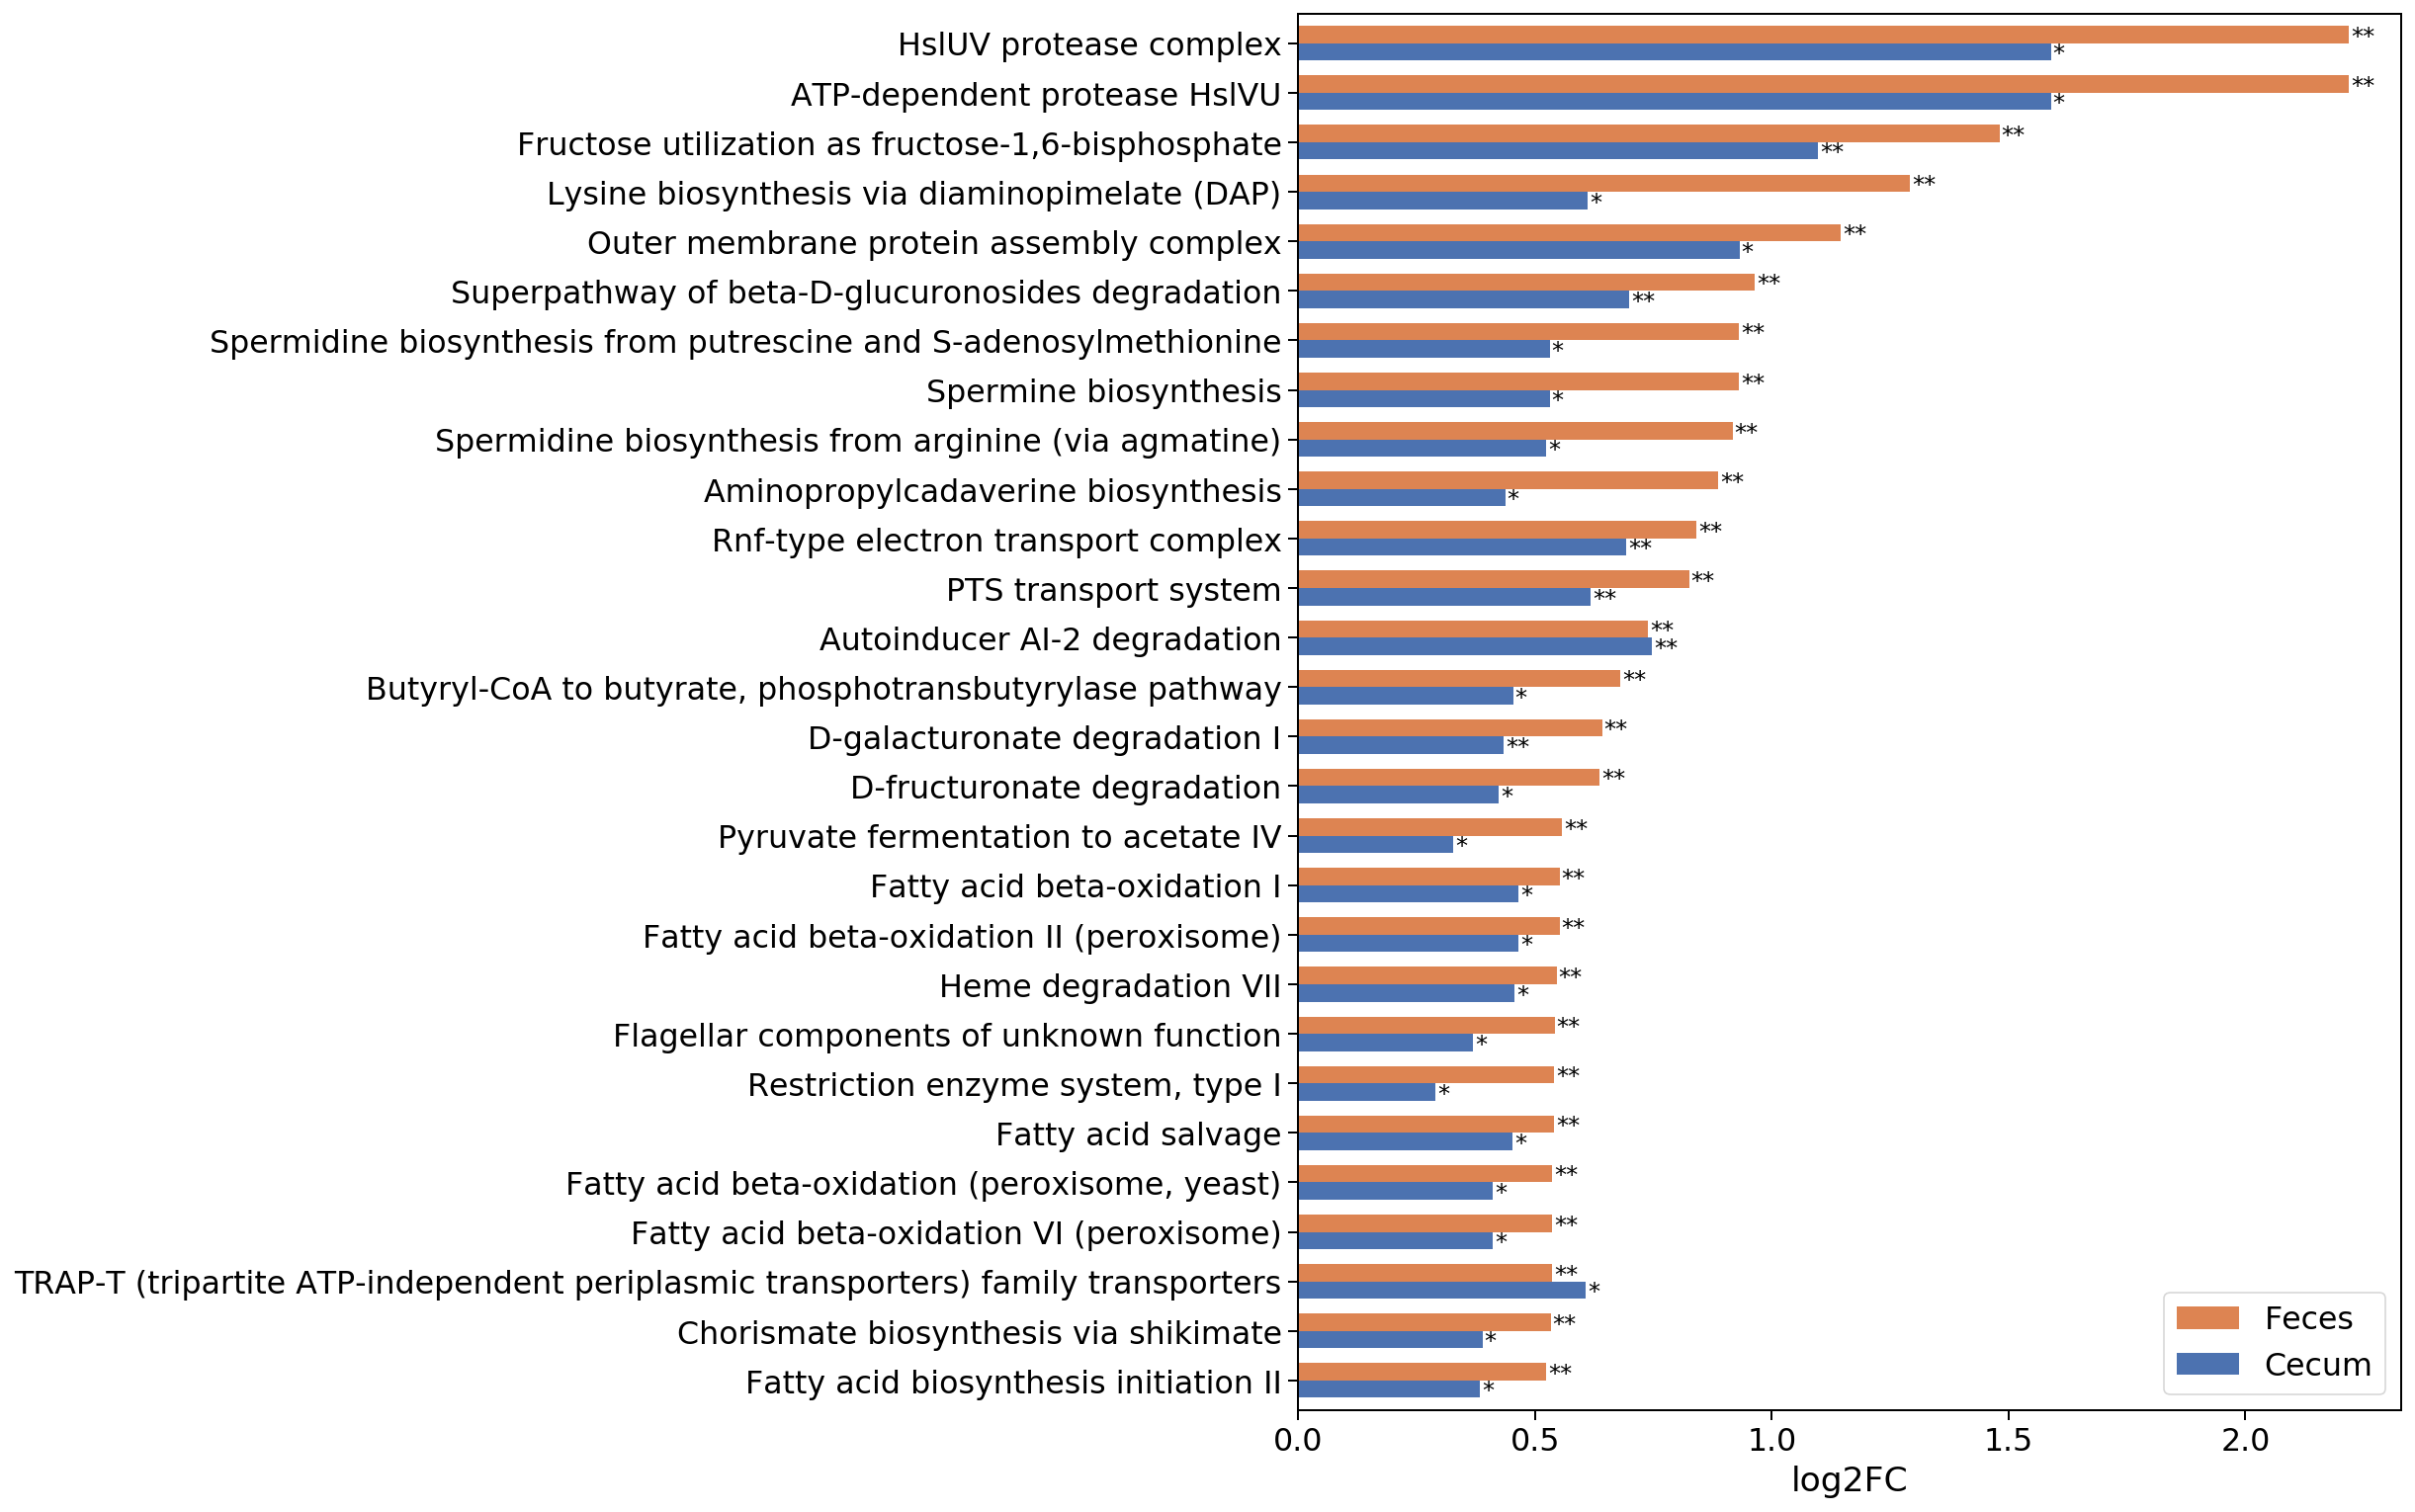

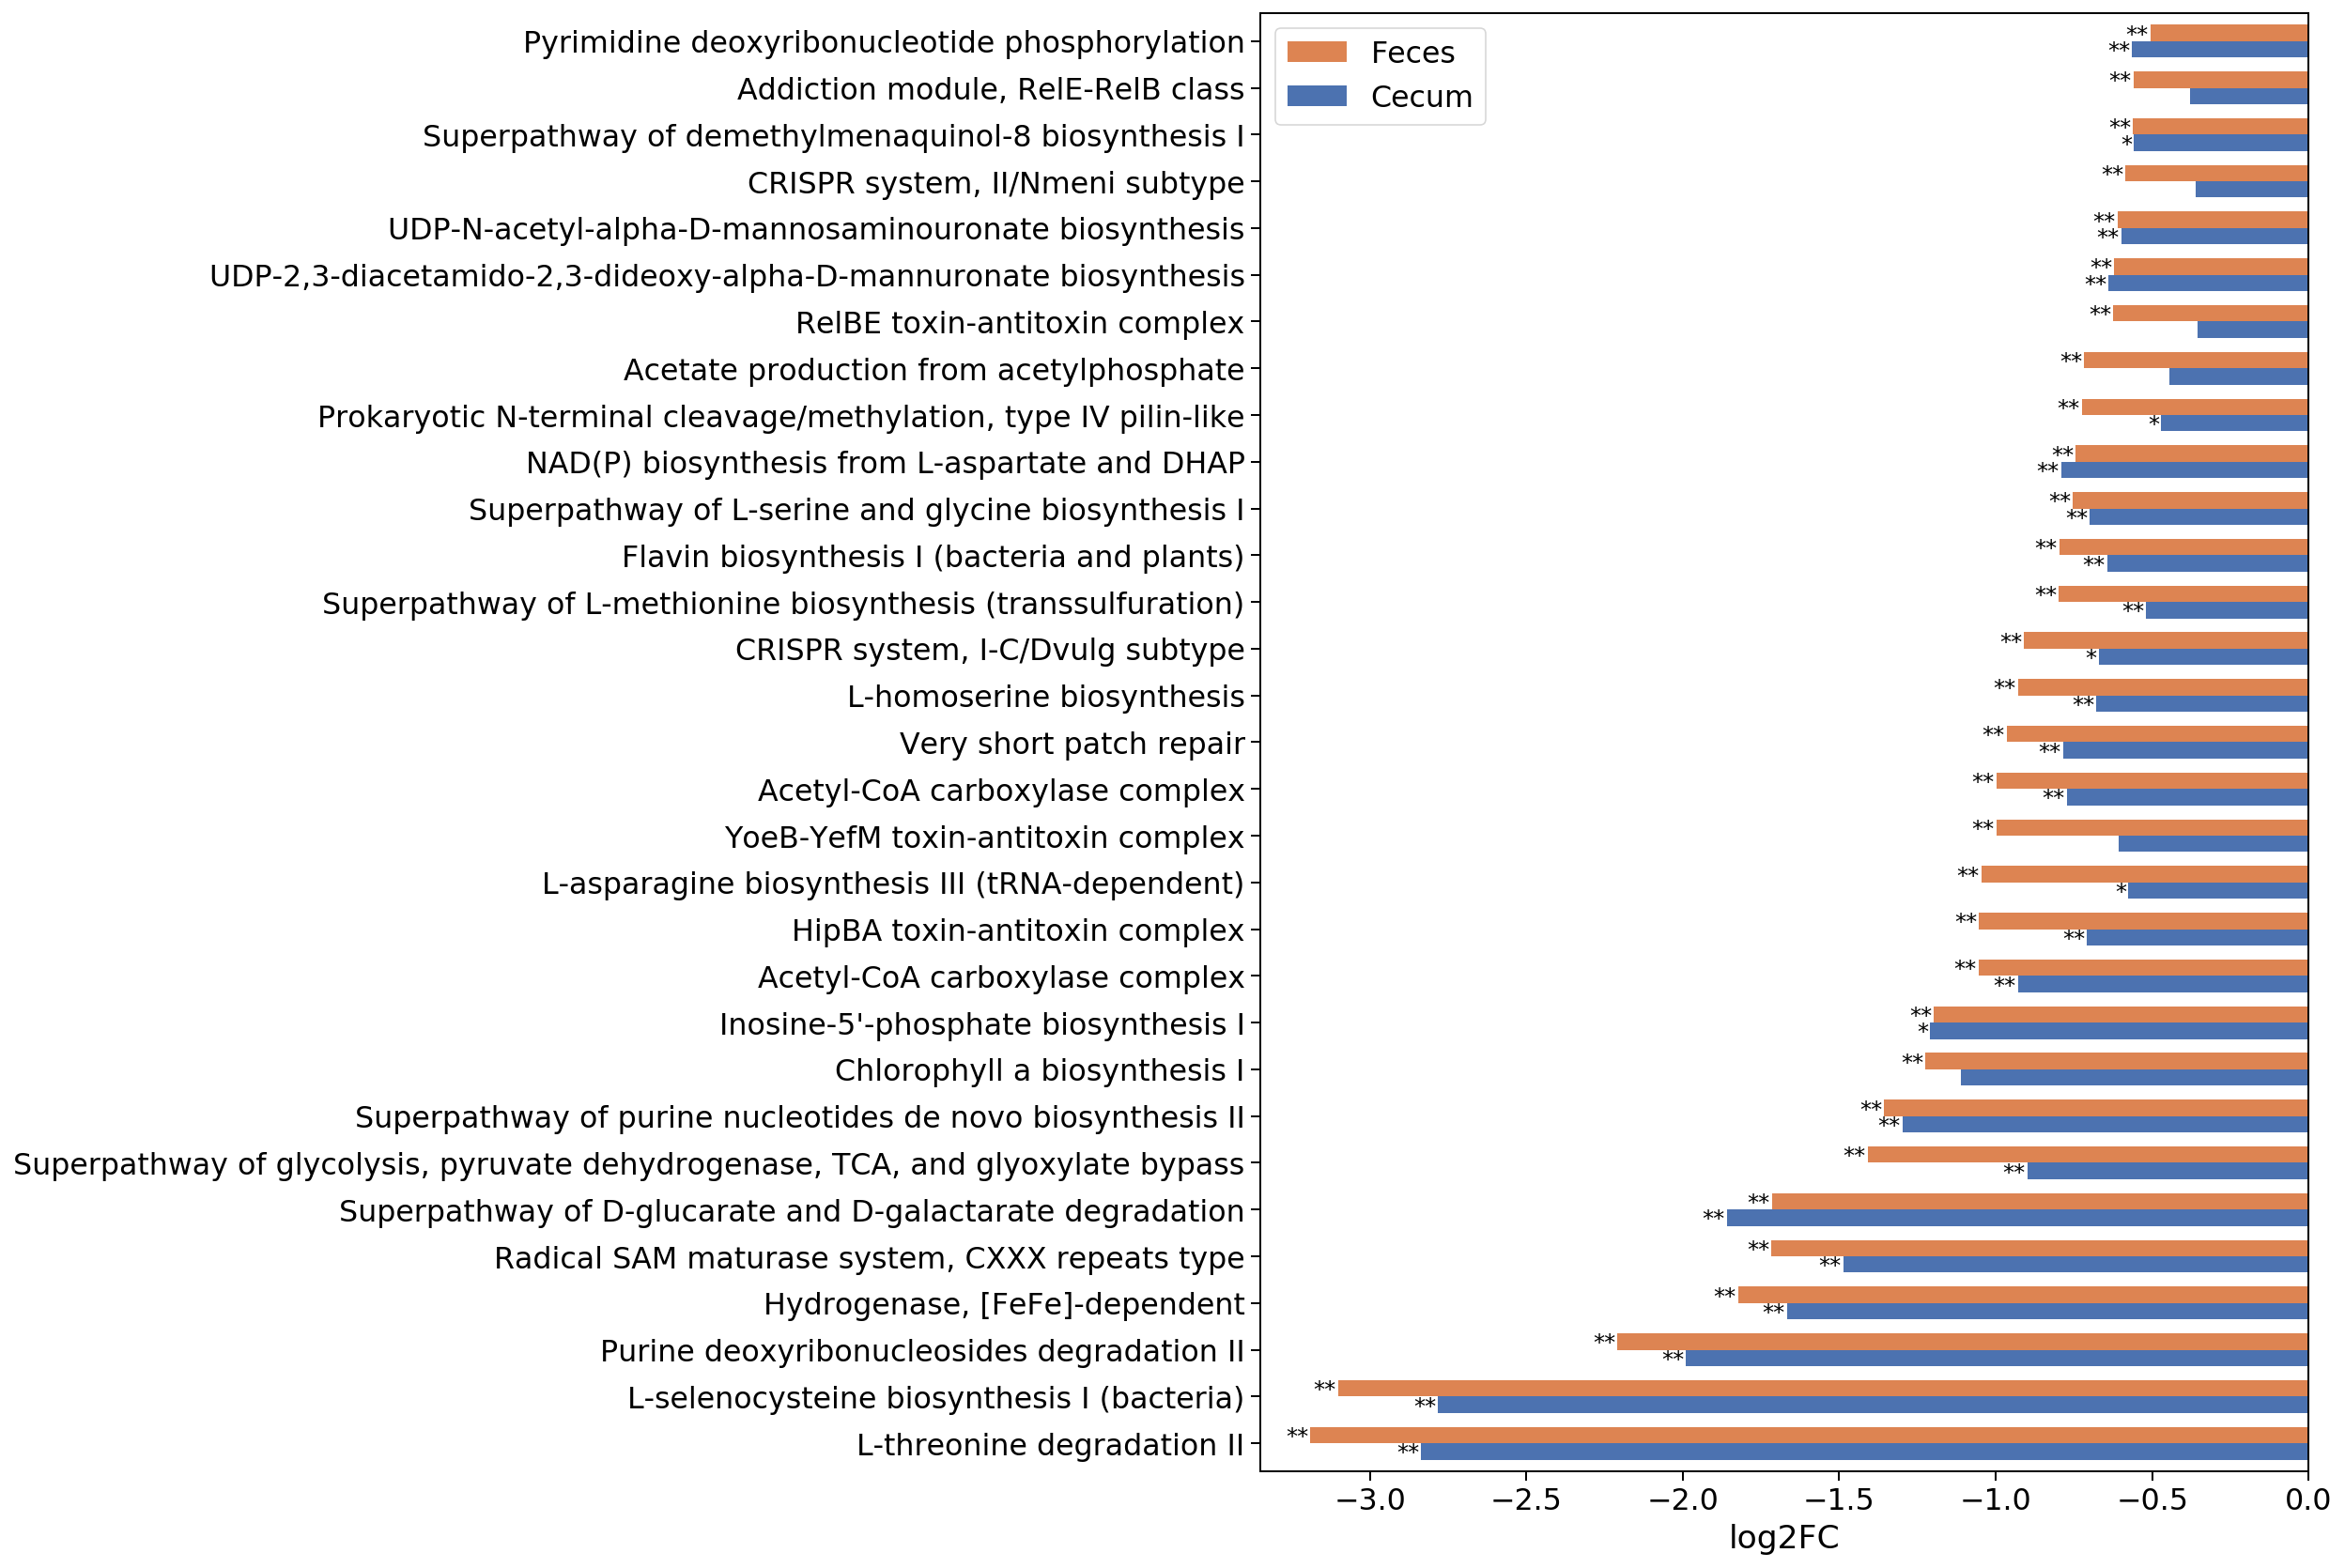

In [226]:
sns.set_palette('deep')


subset=Effect.loc[sig].query(f'{Source}>0').index

EP.effect_plot(Effect.loc[subset], Stats.loc[subset,'pBH'],Labels=Description)
_= plt.xlabel(effect)
plt.ylabel('',visible=False)

hs.plotting.saveplot(f'Effectplot_increased_{sig_label}',**plot_params)
plt.show()
subset=Effect.loc[sig].query(f'{Source}<0').index

EP.effect_plot(Effect.loc[subset], Stats.loc[subset,'pBH'],Labels=Description)
_= plt.xlabel(effect)
plt.ylabel('',visible=False)

hs.plotting.saveplot(f'Effectplot_decreased_{sig_label}',**plot_params)

In [144]:
effect_plot= hs.effect_plot.effect_plot

/Users/silas/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.
/Users/silas/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:910: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


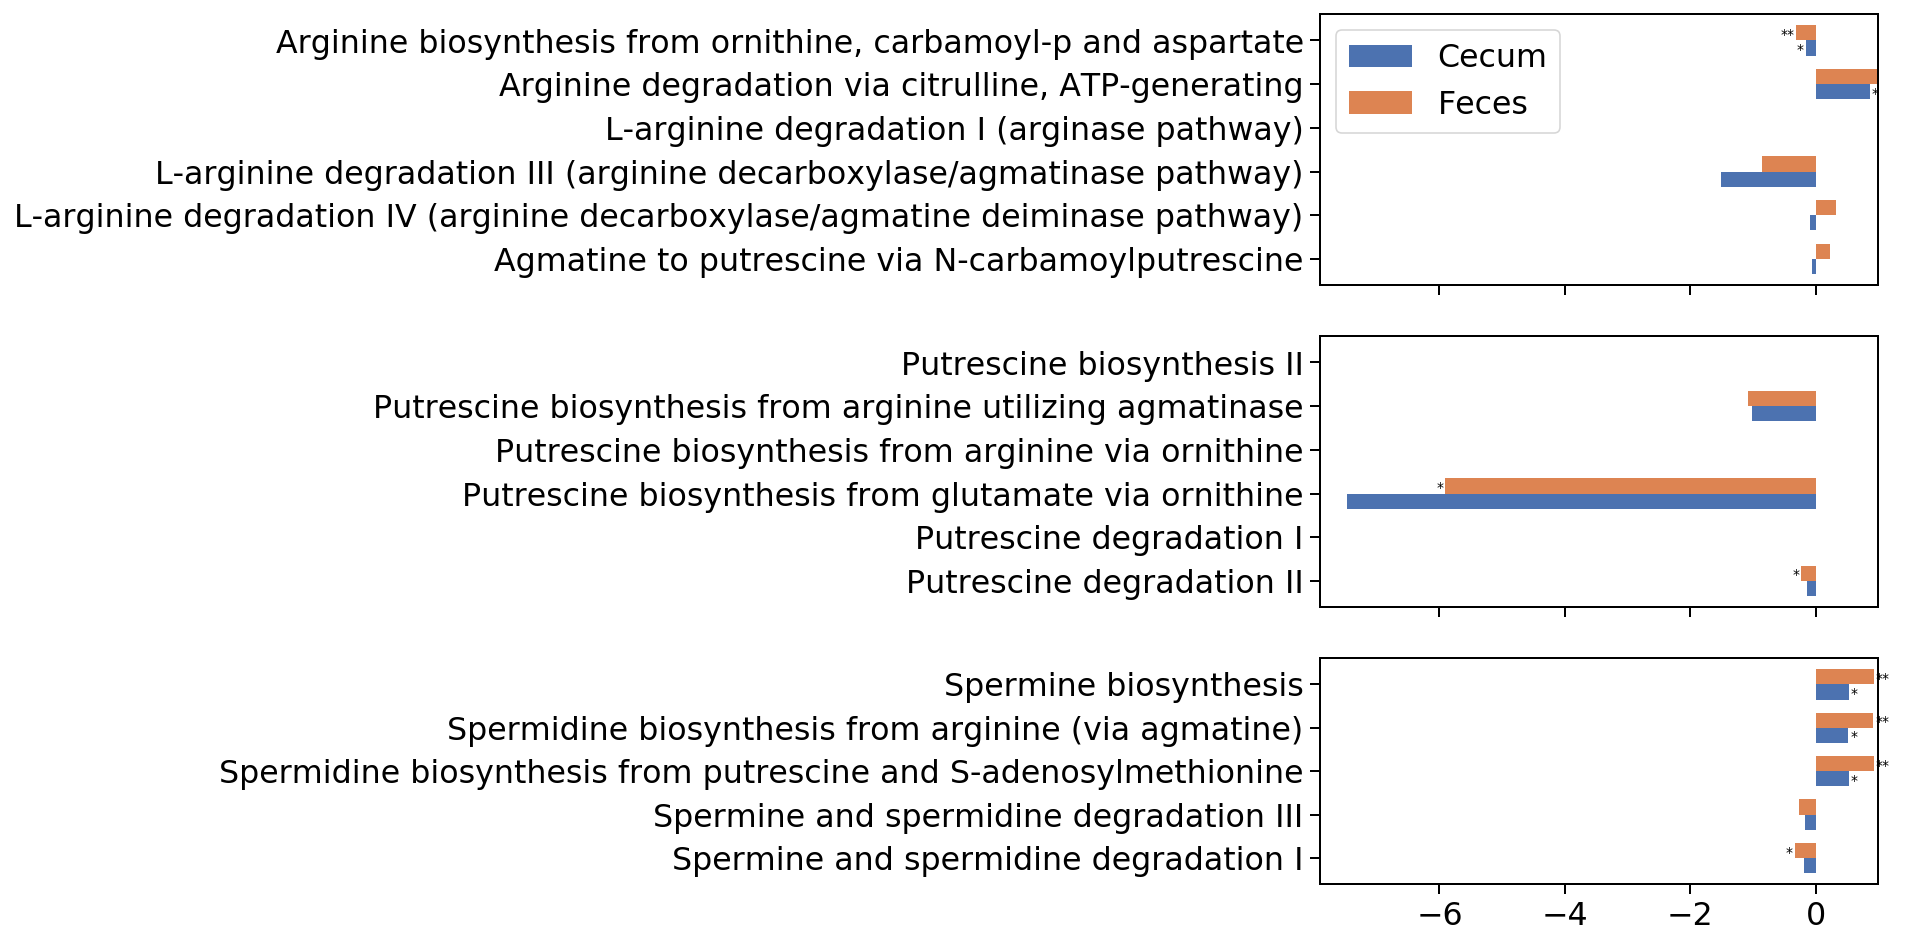

In [145]:

#'1279','1433','1276','0309'


f, axe=plt.subplots(3,1,sharex=True,figsize=(5,8),gridspec_kw=dict(height_ratios=[6,6,5]))

selected="GenProp" + pd.Series(['0117','0639','1428','1282','1431','0738'])
effect_plot(Effect.loc[selected], Stats.loc[selected,'pBH'],Labels=Description,ax=axe[0])

selected="GenProp" + pd.Series(["1733","0642","0643","0644",'1362',"1434"])
effect_plot(Effect.loc[selected], Stats.loc[selected,'pBH'],Labels=Description,ax=axe[1])

selected="GenProp" + pd.Series(['1571', '0219','0641']+['1272','1610'])
effect_plot(Effect.loc[selected], Stats.loc[selected,'pBH'],Labels=Description,ax=axe[2])

_= axe[0].set_xlabel(effect)
axe[2].set_xlim(right=1)
for ax in axe:
    ax.set_ylabel('',visible=False)
    ax.legend().set_visible(False)
axe[0].legend().set_visible(True)
hs.plotting.saveplot(f'Effectplot_amines',**plot_params)

In [129]:
Description.name='Description'

In [130]:
#df= Stats.loc[selected]
df=Stats

df[list(zip(2*[effect],Effect.columns))]=Effect
df[list(zip(2*['Abundance'],Ab.columns))]=Ab

df=df.swaplevel(axis=1)['Feces']

df['Description']=Description


df.sort_values('Pvalue',inplace=True)
#df[('Description','Description')]=Description

df['log10P']= -df.Pvalue.astype(float).apply(np.log10)

df.query('log2FC>0')

,Pvalue,Statistic,median_diff,pBH,log2FC,Abundance,Description,log10P
Genome_Property_ID,,,,,,,,
GenProp1476,0.00077753,11.2941,0.100137,0.005831,0.738017,0.250069,Autoinducer AI-2 degradation,3.109283
GenProp1302,0.00077753,11.2941,0.052598,0.005831,0.245178,0.336543,Galactolipid biosynthesis I,3.109283
GenProp1626,0.00077753,11.2941,0.102500,0.005831,0.253110,0.636986,L-alanine degradation I,3.109283
GenProp1447,0.00077753,11.2941,0.037492,0.005831,1.035996,0.073181,Methanogenesis from methylthiopropanoate,3.109283
GenProp1227,0.00077753,11.2941,0.092771,0.005831,4.388558,0.097422,Guanosine deoxyribonucleotides de novo biosynt...,3.109283
...,...,...,...,...,...,...,...,...
GenProp1171,0.916359,0.0110294,0.001112,0.930243,0.001749,0.917355,YgjD-YeaZ-YjeE complex,0.037934
GenProp1089,0.916359,0.0110294,0.000380,0.930243,0.116812,0.004885,B12-dependent trimeric diol/glycerol dehydratase,0.037934
GenProp1507,1,0,0.003719,1.000000,0.169882,0.033481,L-homocysteine biosynthesis,-0.000000


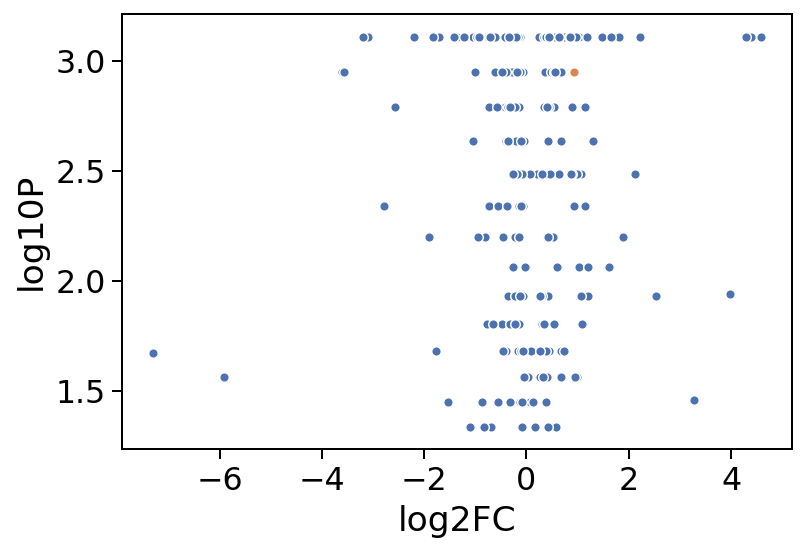

In [101]:
sns.scatterplot(x='log2FC',y='log10P',data=df.query("(Pvalue<0.05)"))

spermidine="GenProp" + pd.Series(['1571', '0219','0641'])

sns.scatterplot(x='log2FC',y='log10P',data=df.loc[spermidine])


In [120]:
df.loc[spermidine]

,Pvalue,Statistic,median_diff,pBH,log2FC,Abundance,Description,log10P
Genome_Property_ID,,,,,,,,
GenProp1571,0.000304,-6.115389,0.094762,0.001369,0.930723,0.199329,Spermine biosynthesis,3.517184
GenProp0219,0.000158,-5.823979,0.089446,0.000860,0.917339,0.190102,Spermidine biosynthesis from arginine (via agm...,3.801084
GenProp0641,0.000304,-6.115389,0.094762,0.001369,0.930723,0.199329,Spermidine biosynthesis from putrescine and S-...,3.517184


In [76]:
goi = 'GenProp1571'#"TIGR00417"

In [77]:
goi

'GenProp1571'

GenProp1337 Vitamin E biosynthesis (tocopherols)


KeyError: 'GenProp1337'

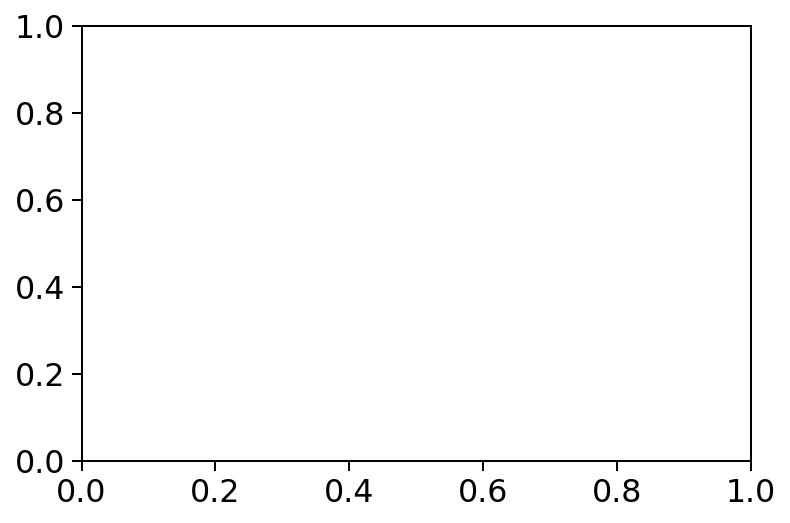

In [79]:
for goi in ['GenProp1337']:
    print(goi,Description[goi])

    M.boxplot(goi,distance_between_sig_labels=0)
    ax= plt.gca()
    ax.set_title(ax.get_ylabel())
    _=ax.set_ylabel('Abundance')

    hs.plotting.saveplot('Stats '+Description[goi],**plot_params)
    plt.show()

In [ ]:
genprop_tree[goi].databases

In [ ]:
MAGs_with_pathway=presence_absence.query(f'{goi}==1').index

In [80]:
sig="GenProp" + pd.Series(['1272','1610']) #['1571', '0219','0641']) #['1272','1610'])#)
label='Spermine and Spermidine degradation'
                             
                             #+[,'1433',"0642","0643","0644", "1733"])
        
Description.loc[sig]

Genome_Property_ID
GenProp1272    Spermine and spermidine degradation III
GenProp1610      Spermine and spermidine degradation I
dtype: object

In [82]:
sig="GenProp" + pd.Series(['1571', '0219','0641']) #['1272','1610'])#)
label='Spermine and Spermidine synthesis'
                             
                             #+[,'1433',"0642","0643","0644", "1733"])
        
Description.loc[sig]

Genome_Property_ID
GenProp1571                                Spermine biosynthesis
GenProp0219    Spermidine biosynthesis from arginine (via agm...
GenProp0641    Spermidine biosynthesis from putrescine and S-...
dtype: object

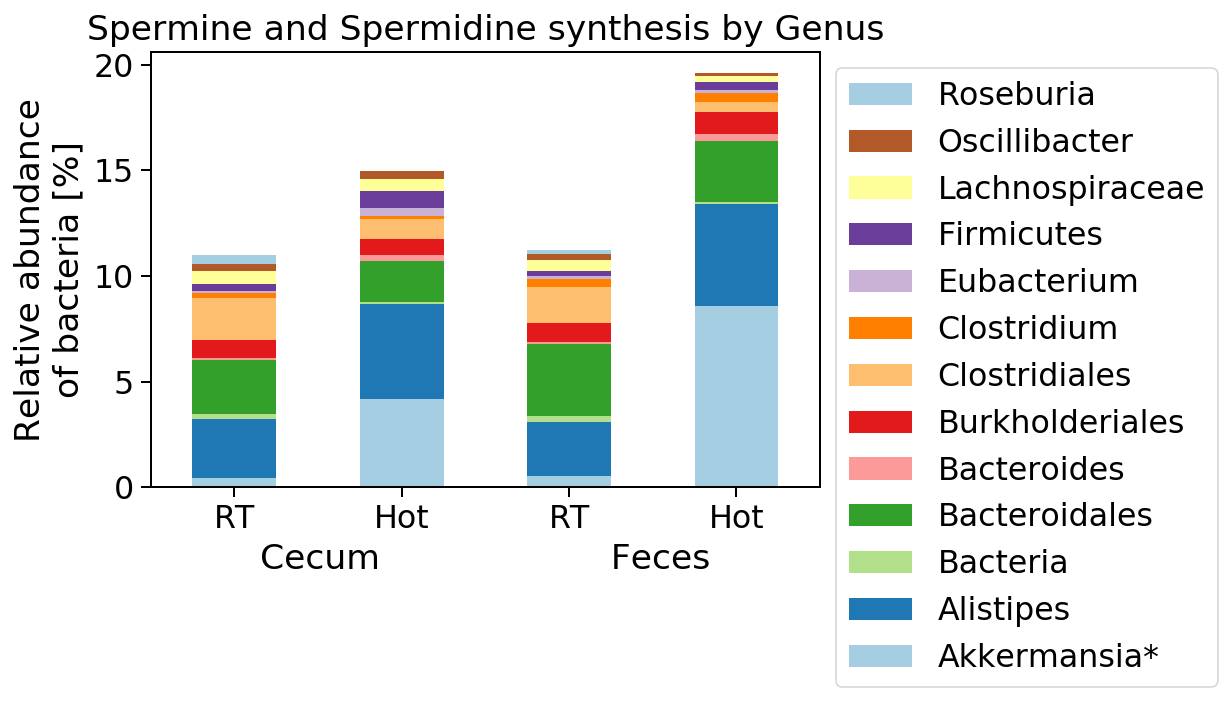

In [83]:
MAGs_with_pathway=presence_absence.index[presence_absence.loc[:,sig].any(1)]

sns.set_palette('Paired')

plot_data= D[MAGs_with_pathway].groupby(Tax.genus,axis=1).sum().groupby([metadata.Source,metadata.Group]).mean()
plot_data=plot_data.loc[[('Cecum', 'RT'),('Cecum', 'Hot'),('Feces', 'RT'), ('Feces', 'Hot')]]
plot_data= plot_data.loc[:,plot_data.max()>0.001]*100
ax=plot_data.plot.bar(stacked=True)
handles, labels=ax.get_legend_handles_labels()

ax.legend(reversed(handles),reversed(labels),bbox_to_anchor=(1,1))

ax.set_ylabel('Relative abundance\nof bacteria [%]')
ax.set_xticklabels(['RT','Hot']*2,rotation=0)
ax.set_xlabel('Cecum                     Feces')
#ax.set_title(Description[goi]+' by Genus')
ax.set_title(label+' by Genus')

hs.plotting.saveplot((label+' by Genus').replace(' ','_'),**plot_params)

In [69]:
Tax.loc[MAGs_with_pathway]#.query('genus=="Bacteroides"')

,superkingdom,phylum,class,order,family,genus,species
MAG007,Bacteria,Firmicutes,Firmicutes,Firmicutes,Firmicutes,Firmicutes,Firmicutes
MAG008,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae,Lachnospiraceae
MAG012,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides
MAG015,Bacteria,Firmicutes,Firmicutes,Firmicutes,Firmicutes,Firmicutes,Firmicutes
MAG020,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiales,Clostridiales,Clostridiales
MAG026,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae,Lachnospiraceae bacterium A4
MAG028,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidales,Bacteroidales,Bacteroidales
MAG030,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae,Lachnospiraceae bacterium 10-1
MAG036,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae,Muribaculaceae
MAG037,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae,Muribaculaceae


In [70]:
sig_Genomes=['MAG118', 'MAG035', 'MAG031', 'MAG001', 'MAG099', 'MAG012', 'MAG082',
       'MAG040', 'MAG058']

spermidine_synthesis= "GenProp" + pd.Series(['1571', '0219','0641'])
Isig=I.loc[sig_Genomes]
Isig.loc[:,spermidine_synthesis].rename(columns=Description)

Genome_Property_ID,Spermine biosynthesis,Spermidine biosynthesis from arginine (via agmatine),Spermidine biosynthesis from putrescine and S-adenosylmethionine
MAG118,0.0,0.0,0.0
MAG035,0.0,0.0,0.0
MAG031,1.0,1.0,1.0
MAG001,0.0,0.0,0.0
MAG099,0.0,0.0,0.0
MAG012,0.0,0.5,0.0
MAG082,1.0,1.0,1.0
MAG040,0.0,0.0,0.0
MAG058,0.0,0.5,0.0


In [71]:
T

NameError: name 'T' is not defined

In [72]:
Tax.loc[["MAG031", "MAG082"]]

,superkingdom,phylum,class,order,family,genus,species
# bin,,,,,,,
MAG031,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia*,Akkermansia*
MAG082,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidales,Bacteroidales,Bacteroidales
